## Exercise 3 

In [1]:

# Option A: A hexbin map of Big data

# Use internet speed data from Ookla, first quarter of 2022, and visualize one of the columns you find interesting 
# (average download speed, upload speed, latency etc.). Use a static Hexbin map for visualization and map the average value of the column in the hexagons. 
# Feel free to be creative and also use other methods to visualize your data. 
# You can try other vsiulization approaches if you can justify your choice.

In [5]:
from pathlib import Path
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
from palettable.colorbrewer.diverging import BrBG_10
from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap

In [6]:

# fetching the data 

url = "https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2022/quarter=1/2022-01-01_performance_mobile_tiles.parquet"

local_path = Path("data/internet-latency.parquet")

if local_path.exists():
    latency = gpd.read_parquet(local_path)
else:
    columns = ["avg_lat_ms", "tile"]
    df = pd.read_parquet(url, columns=columns)

    tile_geometries = shapely.from_wkt(df["tile"])
    tile_centroids = shapely.centroid(tile_geometries)
    latency = gpd.GeoDataFrame(df[["avg_lat_ms"]], geometry=tile_centroids, crs='EPSG:4326')
    latency.to_parquet(local_path)

In [7]:
print(latency.head())
print(f"There are {len(latency)} records in our dataset")

   avg_lat_ms                     geometry
0          77  POINT (-160.02411 70.64268)
1          83  POINT (-160.04059 70.63539)
2          75  POINT (-160.03510 70.63539)
3          83  POINT (-160.02411 70.64086)
4          72  POINT (-160.02411 70.63904)
There are 3820724 records in our dataset


In [8]:
# Creat a map instance
#layer = ScatterplotLayer.from_geopandas(latency)
#m = Map(layer)
#m

In [10]:
!pip install h3
import h3

from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import mapclassify
from shapely import Polygon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.9 MB/s eta 0:00:00:00:0100:01


In [11]:

# Function to assign hexagon using H3
def assign_hexagon(row, resolution=4):
    return h3.latlng_to_cell(row.geometry.y, row.geometry.x, resolution)


# Apply function to data
latency['hex_id'] = latency.apply(assign_hexagon, axis=1)





In [12]:
print(latency.head())

   avg_lat_ms                     geometry           hex_id
0          77  POINT (-160.02411 70.64268)  840d1c1ffffffff
1          83  POINT (-160.04059 70.63539)  840d1c1ffffffff
2          75  POINT (-160.03510 70.63539)  840d1c1ffffffff
3          83  POINT (-160.02411 70.64086)  840d1c1ffffffff
4          72  POINT (-160.02411 70.63904)  840d1c1ffffffff


In [13]:
latency["avg_lat_ms"].max()

3775

In [14]:
# Aggregate data within each hexagon

average_per_hex = latency.groupby('hex_id')['avg_lat_ms'].mean().reset_index()

#hex_counts.columns = ['hex_id', 'count']

In [15]:
type(average_per_hex)

pandas.core.frame.DataFrame

In [16]:
average_per_hex.head()

,hex_id,avg_lat_ms
0,8401201ffffffff,62.800000
1,8401203ffffffff,107.000000
2,8401205ffffffff,58.000000
3,8401207ffffffff,71.111111
4,8401209ffffffff,63.700000


In [17]:
# Generate hexagon geometries

average_per_hex['geometry'] = average_per_hex['hex_id'].apply(
    lambda x: Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(x)])
)



hex_gdf = gpd.GeoDataFrame(average_per_hex, geometry='geometry')



#def hex_to_polygon(hex):
#    return Polygon([(lon, lat) for lon, lat in hex])

#average_per_hex['geometry'] = average_per_hex['geometry'].apply(hex_to_polygon)


In [18]:
hex_gdf.head()

,hex_id,avg_lat_ms,geometry
0,8401201ffffffff,62.800000,"POLYGON ((24.37600 70.48484, 24.93249 70.56916..."
1,8401203ffffffff,107.000000,"POLYGON ((23.77067 70.79691, 24.33344 70.88372..."
2,8401205ffffffff,58.000000,"POLYGON ((25.50325 70.45261, 26.06599 70.53352..."
3,8401207ffffffff,71.111111,"POLYGON ((24.91788 70.76877, 25.48736 70.85213..."
4,8401209ffffffff,63.700000,"POLYGON ((23.85259 70.20126, 24.39655 70.28645..."


In [19]:
# find out count of 0.0 values

print("Valid:", hex_gdf.is_valid.all())
print("Empty geometries:", hex_gdf.is_empty.sum())

Valid: True
Empty geometries: 0


In [27]:
import matplotlib.colors as mcolors
mycmap = mcolors.ListedColormap(["#7FD1B9","#7C90DB", "#E6AA68", "#D36135", "#590004"])

# "#94C9A9"

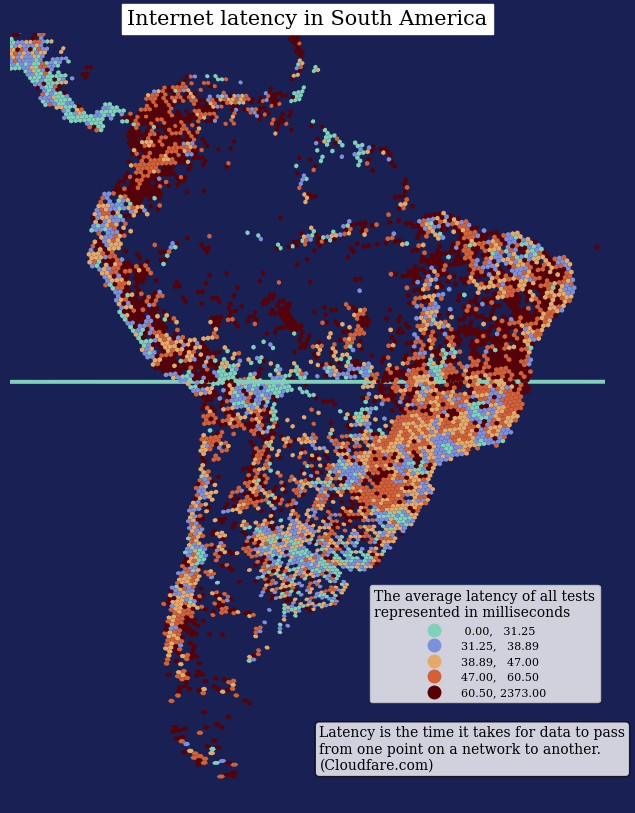

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor="#182054")

# for zoomin to Helsinki area, if needed
helsinki_bounds = {
    "min_lon": -88.945313,
    "max_lon": -31.640625,
    "min_lat": -57.515823,
    "max_lat": 16.636192
}

import matplotlib.font_manager as fm
custom_font = fm.FontProperties(family='serif', weight='normal', size=8)

# Set the bounds for the plot to zoom into x. if desired 
ax.set_xlim(helsinki_bounds["min_lon"], helsinki_bounds["max_lon"])
ax.set_ylim(helsinki_bounds["min_lat"], helsinki_bounds["max_lat"])

hex_gdf.plot(ax=ax, column="avg_lat_ms",scheme="quantiles", k=5, cmap=mycmap, legend=True, legend_kwds={"title": "The average latency of all tests\nrepresented in milliseconds", "frameon" : True, 'facecolor': '#FFFFFF', 'bbox_to_anchor': (1
                                                                                                                                                                                                                      , 0.29),  "prop": custom_font, 'labelcolor': 'black'})

# legend_kwds={"loc": "center right", "frameon" : False, "fancybox" : False, "prop": custom_font, "ncol" : 2, 'bbox_to_anchor': (0.2, 1)}, edgecolors='none') edgecolors='white'


legend = ax.get_legend()
title = legend.get_title()
title.set_fontsize(10)
title.set_fontweight('normal')
title.set_family('serif')

# Remove axis
ax.axis('off')

# set title
ax.set_title("Internet latency in South America", loc='center', fontsize=15, fontweight='book', family='serif', backgroundcolor= '#FFFFFF')



textstr = "Latency is the time it takes for data to pass\nfrom one point on a network to another.\n(Cloudfare.com)"

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax.text(0.52, 0.1, textstr, transform=ax.transAxes, fontsize=10, family='serif',
        verticalalignment='top', bbox=props)

# Save the figure
#ax.savefig(NOTEBOOK_PATH / 'house_map.png', bbox_inches='tight')
plt.savefig("latency.png", dpi=300, bbox_inches='tight')
plt.show()



In [59]:
# choose colours
# move the boxes around 
# alpha of the boxes?


In [36]:
print(hex_gdf.crs)

None


In [35]:
type(hex_gdf)

geopandas.geodataframe.GeoDataFrame

In [37]:
hex_gdf_copy = hex_gdf.set_crs("EPSG:4326")

In [38]:
print(hex_gdf_copy.crs)

EPSG:4326


In [40]:
type(hex_gdf_copy)

geopandas.geodataframe.GeoDataFrame

In [41]:
hex_gdf_copy.head()

,hex_id,avg_lat_ms,geometry
0,8501200ffffffff,61.0,"POLYGON ((24.51235 70.73684, 24.67079 70.78969..."
1,85012013fffffff,71.0,"POLYGON ((24.37600 70.48484, 24.53163 70.53750..."
2,8501201bfffffff,63.0,"POLYGON ((24.77516 70.51677, 24.93249 70.56916..."
3,85012023fffffff,107.0,"POLYGON ((23.83491 70.92361, 23.99266 70.97720..."
4,85012057fffffff,58.0,"POLYGON ((25.17628 70.54788, 25.33531 70.59999..."


<Axes: >

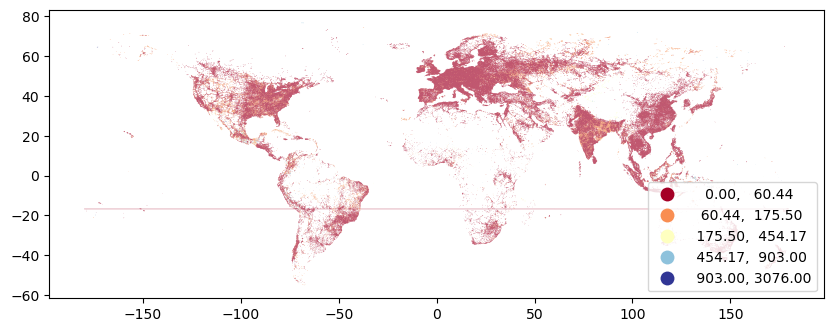

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
hex_gdf_copy.plot(ax=ax, column="avg_lat_ms",scheme="Natural_Breaks", k=5, cmap="RdYlBu", legend=True, legend_kwds={'loc': 'lower right'})

In [46]:
hex_gdf_copy.to_crs("EPSG:3857")

,hex_id,avg_lat_ms,geometry
0,8501200ffffffff,61.000000,"POLYGON ((2728702.226 11312886.281, 2746339.61..."
1,85012013fffffff,71.000000,"POLYGON ((2713523.812 11228385.081, 2730848.16..."
2,8501201bfffffff,63.000000,"POLYGON ((2757958.430 11239034.726, 2775472.54..."
3,85012023fffffff,107.000000,"POLYGON ((2653290.596 11376203.186, 2670850.22..."
4,85012057fffffff,58.000000,"POLYGON ((2802610.492 11249426.100, 2820314.29..."
...,...,...,...
143673,85df6a7bfffffff,62.636364,"POLYGON ((-7557057.250 -7143922.842, -7541239...."
143674,85df6ab3fffffff,15.000000,"POLYGON ((-7715636.270 -7140541.802, -7699764...."
143675,85df6babfffffff,47.250000,"POLYGON ((-7705530.782 -6949219.889, -7701546...."
143676,85df6bb3fffffff,34.000000,"POLYGON ((-7748844.429 -6959522.550, -7744166...."


<Axes: >

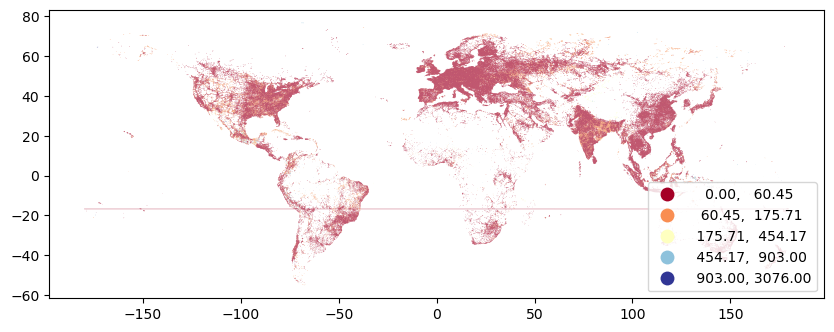

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
hex_gdf_copy.plot(ax=ax, column="avg_lat_ms",scheme="Natural_Breaks", k=5, cmap="RdYlBu", legend=True, legend_kwds={'loc': 'lower right'})

## Part 2 Cartogram

Option C: Cartograms

Create an area cartogram. Feel free to use whichever regions you wish. For example, up-to-date population data in various administrative levels of Finland is available via Statistics Finland’s WFS and global population data by country is available, for example, through Natural Earth vector map. Visualize a variable on the map after distorting it.

In [48]:
# https://python-graph-gallery.com/592-non-contiguous-cartogram-in-python/